In [1]:
from glob import glob
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib notebook

In [2]:
path = r"I:\2020_07_17_TS_third_try\*.wav"
filelist = glob(path)
filelist

['I:\\2020_07_17_TS_third_try\\2213_AI0_chirp_half_ms_target.wav',
 'I:\\2020_07_17_TS_third_try\\2217_AI0_chirp_one_ms_target.wav',
 'I:\\2020_07_17_TS_third_try\\2222_AI0_chirp_one_ms_nothing.wav',
 'I:\\2020_07_17_TS_third_try\\2227_AI0_chirp_half_ms_nothing.wav',
 'I:\\2020_07_17_TS_third_try\\2231_AI0_chirp_one_ms_nothing.wav',
 'I:\\2020_07_17_TS_third_try\\2240_AI1_chirp_one_ms_two_hydro.wav',
 'I:\\2020_07_17_TS_third_try\\2240_AI0_chirp_one_ms_two_hydro.wav',
 'I:\\2020_07_17_TS_third_try\\2244_AI1_chirp_half_ms_two_hydro.wav',
 'I:\\2020_07_17_TS_third_try\\2244_AI0_chirp_half_ms_two_hydro.wav']

In [3]:
class SL():
    def __init__(self, file):
        self.file = file
        self.bits = 24
        self.range = 2
        title = self.file.split('\\')[-1].split('.')[0].split('_')
        self.plot_title = title[1] + "_" + title[2] + '_' + title[3] + "_" + title[4] + '_' + title[5] + "_" + title[6]
        self.freq = title[2]
        print("title: {}".format(self.plot_title))
    def readWavFileToArray(self):
#         fp = open(self.file, 'r')
#         self.fs, self.values = wavfile.read(self.file)
#         self.values = self.values*(self.range/pow(2,self.bits))
        self.values, self.fs = sf.read(self.file)
        self.values = self.values-np.mean(self.values)
        self.length = len(self.values)
        self.time = np.arange(self.length)/self.fs
        print("total lenght: {}, time duration: {}".
              format(self.length, self.length//self.fs))
    def plot(self):
        plt.plot(self.time, self.values)
        plt.title(self.plot_title)
    def findPeakIndex(self, threshold):
        mask = ((self.values[1:-1]-self.values[2:])>0)*((self.values[1:-1]-self.values[:-2])>0)*(self.values[1:-1]>threshold)
        self.indexs = []
        for index, i in enumerate(mask):
            if(i):
                self.indexs.append(index+1)
        count=1
        self.indexs = np.array(self.indexs)
        diff = self.indexs[1:]-self.indexs[:-1]
        
        start_skip=0
        end_skip=0
        self.category=[]
        self.category.append(self.indexs[start_skip])
        for index, value in enumerate(diff):
            if value>self.fs:
                count+=1
                self.category.append(self.indexs[index-end_skip])
                self.category.append(self.indexs[index+1+start_skip])
        self.category.append(self.indexs[-(1+end_skip)])
        print("total sound generated: {}".format(count))
    def plotWithPeak(self):
        fig, ax = plt.subplots()
        ax.plot(self.time, self.values)
        ax.plot(self.time[self.indexs], self.values[self.indexs], 'o')
        ax.set_title(self.plot_title)
        fig.tight_layout()
    def plotWithFilterPeak(self):
        fig, ax = plt.subplots()
        ax.plot(self.time, self.values)
        ax.plot(self.time[self.category], self.values[self.category], 'o')
        ax.set_title(self.plot_title)
        fig.tight_layout()
    
    def rms(self, x):
        return np.sqrt(np.mean(x*x))
    def calculateSL(self):
        self.sen = -207
        length = len(self.indexs)
        if (length>0):
            self.SL_list=[]
            for i in range(length):
                index = self.indexs[i]
                start = index-int(0.00025*self.fs)
                end = start+int(0.0005*self.fs)
                
                v = self.rms(self.values[start:end])
                sl = 20*math.log10(v)-self.sen
                self.SL_list.append(sl)
        else:
            print("the peak is wrong or empty, check the plot with peak")
    def calculateTemplate(self, t):
        #所尋找的template 會直接影響偵測效能，需繪圖找出最適合位置
        duration = t
        start = self.indexs[0]-int(duration*self.fs/2)
        end = start + int(self.fs*duration)

        self.template = np.zeros(int(self.fs*duration))

        for i in range(len(self.indexs)):
            start = self.indexs[i]-int(duration*self.fs/2)
            end = start + int(self.fs*duration)
            
            tank = self.values[start:end]
            self.template = self.template + tank
        self.template = self.template/len(self.indexs)
    def estimateTimeList(self, source_duration, delay_time):
        print("There is no automatically find the peak you should test the index first!")
        self.time_delay_list = []
        fir_coeff = self.template[::-1]
        
        first_peak_index = int((0.001-source_duration/2)*self.fs) + len(fir_coeff) - 1
        first_window_start = first_peak_index - int(0.2*len(fir_coeff))
        first_window_end = first_window_start + int(0.4*len(fir_coeff))

        second_peak_index = first_peak_index + int(delay_time*self.fs)
        second_window_start = second_peak_index - int(0.2*len(fir_coeff))
        second_window_end = second_window_start + int(0.4*len(fir_coeff))
        
        for i in range(len(self.indexs)):
            start = self.indexs[i] - int(0.001*self.fs)
            end = start + int(self.fs*0.01)
            received_signal = self.values[start:end]
            det = np.convolve(fir_coeff, received_signal, "full")
    
            sig_1 = det[first_window_start:first_window_end]
            sig_2 = det[second_window_start:second_window_end]
            arg_1 = np.argmax(sig_1) + first_window_start
            arg_2 = np.argmax(sig_2) + second_window_start
            time_delay = (arg_2-arg_1)
            self.time_delay_list.append(time_delay)
    def estimateAlphaList(self, source_duration):
        self.alpha_list = []
        min_power = 10**10
        target_signal_index = self.indexs + self.time_delay_list
        for i in range(len(self.indexs)):
            target_signal_start = target_signal_index[i]-int(source_duration*self.fs/2)
            target_signal_end = target_signal_start+int(source_duration*self.fs)
            target_signal = self.values[target_signal_start:target_signal_end]
            for j in range(1, 100001):
                alpha = 0.00001*j
                estimated_signal = alpha*self.template
                diff = target_signal - estimated_signal
                power = np.sum(diff*diff)
                if power<min_power:
                    estimated_alpha = alpha
                    min_power = power
            self.alpha_list.append(estimated_alpha)  
    def getSL(self):
        return self.SL
    def getData(self):
        return self.values
    def getIndex(self):
        return self.indexs
    def getTime(self):
        return self.time
    def getTemplate(self):
        return self.template
    def getTimeList(self):
        return self.time_delay_list
    def getAlphaList(self):
        return self.alpha_list
    def getSLList(self):
        return self.SL_list

In [34]:
# source_duration = 0.001
# fir_coeff = template_tank
# first_peak_index = int((0.001-source_duration/2)*fs) + len(fir_coeff) - 1
# first_window_start = first_peak_index - int(0.2*len(fir_coeff))
# first_window_end = first_window_start + int(0.4*len(fir_coeff))

# second_peak_index = first_peak_index + int(delay_time*fs)
# second_window_start = second_peak_index - int(0.2*len(fir_coeff))
# second_window_end = second_window_start + int(0.4*len(fir_coeff))

In [35]:
# (first_window_start, first_window_end)

title: AI0_chirp_half_ms_two_hydro
total lenght: 19600000, time duration: 191


<IPython.core.display.Javascript object>


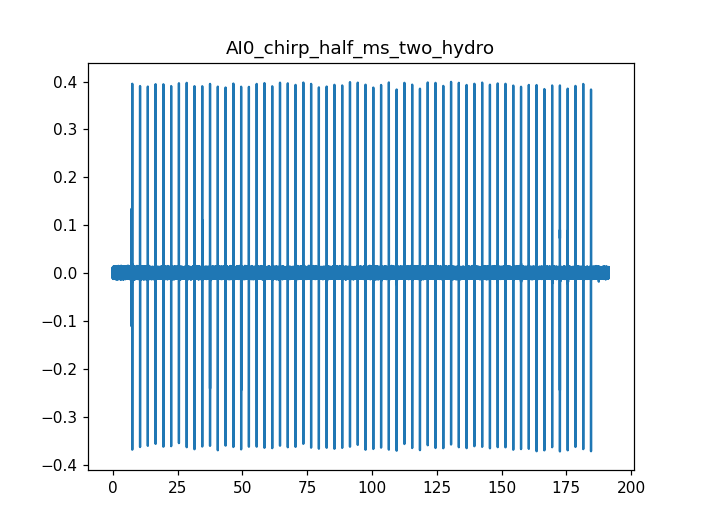

In [4]:
tank = SL(filelist[8])
tank.readWavFileToArray()
tank.plot()

total sound generated: 60


<IPython.core.display.Javascript object>


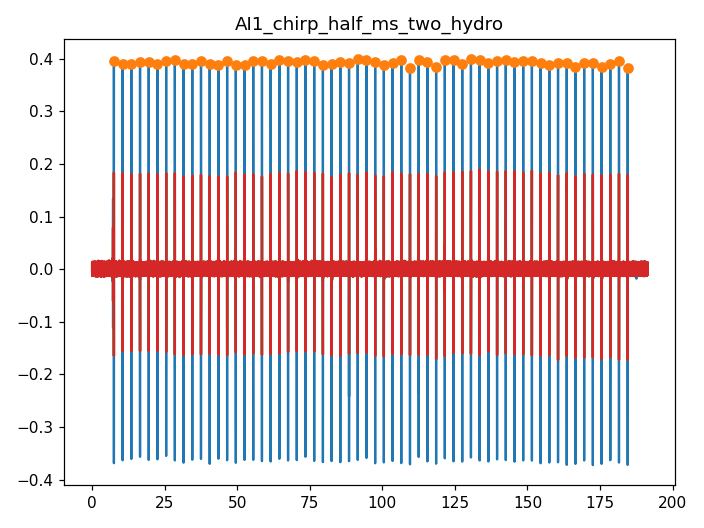

In [5]:
tank.findPeakIndex(0.35)
tank.plotWithPeak()
tank.calculateSL()
sl_list_one = tank.getSLList()

In [6]:
len(sl_list_one)

60

In [7]:
index_tank = tank.getIndex()
data_tank = tank.getData()

tank.calculateTemplate(0.001)
template_tank = tank.getTemplate()

In [8]:
len(index_tank)

60

title: AI1_chirp_half_ms_two_hydro
total lenght: 19600000, time duration: 191
total sound generated: 60


<IPython.core.display.Javascript object>


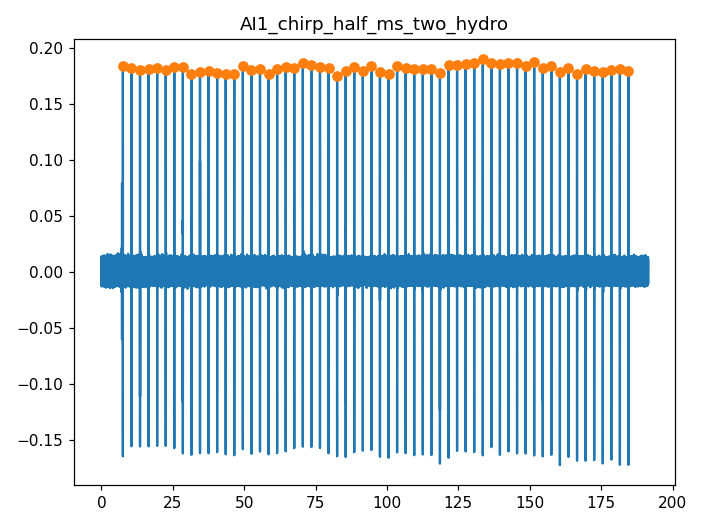

In [10]:
target = SL(filelist[7])
target.readWavFileToArray()
target.plot()
target.findPeakIndex(0.15)
target.plotWithPeak()
target.calculateSL()
sl_list_two = target.getSLList()

In [11]:
TL_list_1 = np.array(sl_list_one)-np.array(sl_list_two)

In [8]:
# TL_list = np.array(sl_list_one)-np.array(sl_list_two)

In [20]:
index_target = target.getIndex()
data_target = target.getData()

target.calculateTemplate(0.001)
template_target = target.getTemplate()

# target.estimateTimeList(source_duration=0.001, delay_time=2/1500)
# delay_time_list = target.getTimeList()
# target.estimateAlphaList(source_duration=0.001)
# alpha_list = target.getAlphaList()

<IPython.core.display.Javascript object>


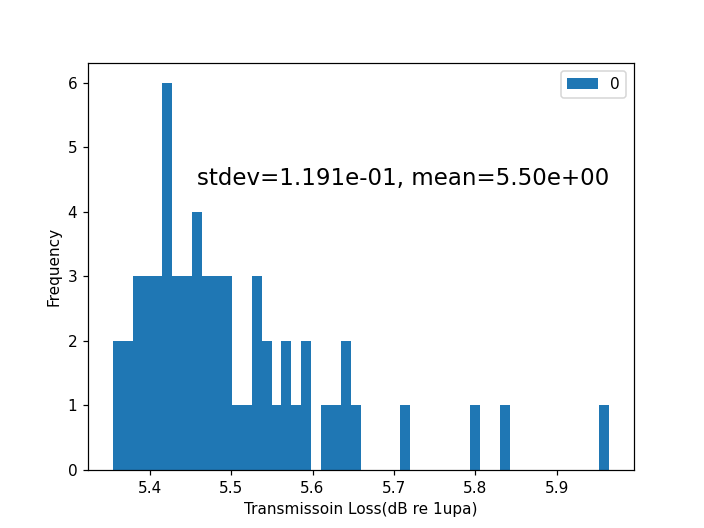

Text(0.2, 0.7, 'stdev=1.191e-01, mean=5.50e+00')

In [49]:
import statistics
import pandas as pd
statistic_list = TL_list

std = statistics.stdev(statistic_list)
mean = statistics.mean(statistic_list)

df = pd.DataFrame(statistic_list)
ax = df.plot.hist(bins=50)

s = "stdev={:.3e}, mean={:.2e}".format(std,mean)
ax.set_xlabel("Transmissoin Loss(dB re 1upa)")
ax.text(0.2, 0.7, s=s, transform=ax.transAxes, fontsize=15)

<IPython.core.display.Javascript object>


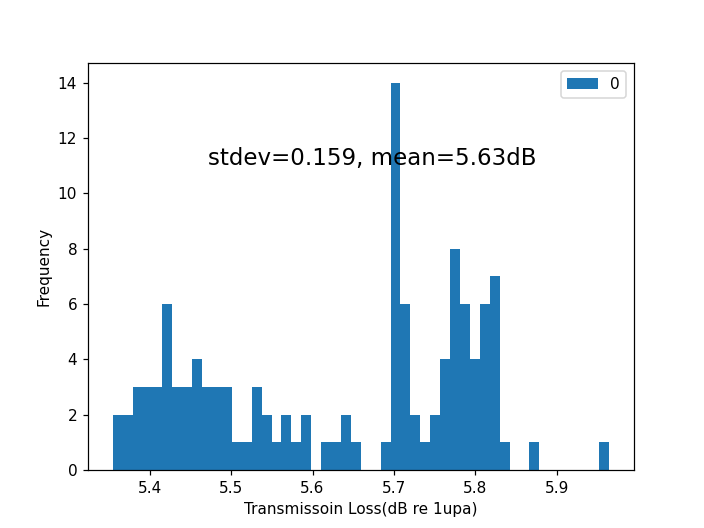

Text(0.22, 0.75, 'stdev=0.159, mean=5.63dB')

In [42]:
import statistics
import pandas as pd
statistic_list = tl

std = statistics.stdev(statistic_list)
mean = statistics.mean(statistic_list)

df = pd.DataFrame(statistic_list)
ax = df.plot.hist(bins=50)

s = "stdev={:.3f}, mean={:.2f}dB".format(std,mean)
ax.set_xlabel("Transmissoin Loss(dB re 1upa)")
ax.text(0.22, 0.75, s=s, transform=ax.transAxes, fontsize=15)

In [51]:
np.save("tl", TL_list)

In [13]:
tl_list = np.load("tl.npy")

In [38]:
np.save("tl", tl)